In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime
import random
import copy
from tqdm import tqdm

# import sklearn
from sklearn.linear_model import LinearRegression, LassoLarsIC, LassoCV, LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.datasets import make_classification, make_moons, make_blobs
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from scipy.stats import multivariate_normal

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.distributions import Bernoulli
# from torchsummary import summary

import multiprocessing as mp

# Data Generation

In [2]:
# ===================== Binary classification =====================================================
def generate_data(m=100, n=20, signal=1, sigma=1, num_support=8, seed=1):
    "Generates data matrix X and observations Y."
    np.random.seed(seed)
    # beta_star = np.random.randn(n)
    # beta_star[num_support:] = 0
        
    beta_star = np.zeros(n)
    beta_star[:num_support] = signal
    X = np.random.randn(m,n)
    logits = X.dot(beta_star) # + np.random.normal(0, sigma, size=m)   # 误差加在这结果会好一些
    p = 1 / (1 + np.exp(-logits))                                    # 误差如果加在这，就会出现一些问题，p和x的关系就会被破坏
    Y = (p > 0.5).astype(np.int)
    return X, Y, beta_star, np.diag(np.ones(n))


# ===================== Multi-class classification =====================================================
# def generate_data(n_samples, n_features, n_informative, n_redundant, n_repeated, n_classes, seed=1):
#     X, Y = make_classification(n_samples=n_samples, 
#                                n_features=n_features, 
#                                n_informative=n_informative, 
#                                n_redundant=n_redundant,
#                                n_repeated = n_repeated,
#                                n_classes=n_classes, 
#                                shuffle=False, random_state=seed)
#     return X, Y

# Architecture

In [3]:
# ==============================================================================================
def get_data(x, y, batch_size=32):
#     x = StandardScaler(with_mean=True, with_std=True).fit_transform(x)
    sample_size = x.shape[0]
    idx = np.random.choice(range(sample_size), batch_size, replace=False)
    return x[idx, :], y[idx, np.newaxis]



class Actor(nn.Module):
    def __init__(self, obs_dim, action_dim):
        '''
        obs_dim: dim_x or (dim_x + dim_y)
        action_dim: dim_x
        '''
        super(Actor, self).__init__()
        
        
        self.fc1 = nn.Linear(in_features=obs_dim, out_features=256)
        self.fc2 = nn.Linear(256, action_dim)
        
    def forward(self, obs):
        obs = torch.tensor(obs, dtype=torch.float)
        logits = F.relu(self.fc1(obs))
        logits = self.fc2(logits)
        
        m = Bernoulli(logits=logits)
        
        actions = m.sample()
        log_probs = m.log_prob(actions)
        entropy = m.entropy()
        
        return actions, log_probs, entropy




def compute_reward(X_train, Y_train, X_test, Y_test, actions, num_iter=500, lr=1e-3, batch_size='auto', dictionary=dict()):
    reward_list = []
    for action in actions.detach().numpy():
        
        idx = np.where(action == 1)[0]
        
        if tuple(idx) in dictionary:
            reward_list.append(dictionary[tuple(idx)])
        else:
            X_select = X_train[:, idx]        
            classifier = MLPClassifier(hidden_layer_sizes=(128,), random_state=1, learning_rate='adaptive', batch_size=batch_size,
                                     learning_rate_init=lr, max_iter=num_iter, tol=1e-3)
#             classifier = RandomForestClassifier(max_depth=5)
            classifier.fit(X_select, Y_train)
            X_select = X_test[:, idx] 
#             probs = classifier.predict_proba(X_select)
#             eps = np.where(probs < 1e-4, 1e-4, 0)
#             log_probs = np.log(probs + eps)
#             log_likelihood = (log_probs[:, 1] * Y_test + log_probs[:, 0] * (1 - Y_test)).mean()
#             predict_proba = classifier.predict_proba(X_select)
#             loss = log_loss(Y_test, predict_proba)
#             dictionary[tuple(idx)] = loss
#             reward_list.append(loss)
            
#             classifier = RandomForestClassifier(max_depth=5)
#             classifier = SVC(gamma='auto')
            # classifier = LogisticRegression()
#             classifier.fit(X_select, Y_train)
            
#             X_select = X_test[:, idx] 
            score = classifier.score(X_select, Y_test)
            dictionary[tuple(idx)] = 1 - score
            reward_list.append(1 - score)
        
    return np.array(reward_list)

In [4]:
# training steps
m = 100
n = 24
sigma = 0.5
num_support = 8
signal = 1
y_true = np.zeros(n, dtype=np.int)
y_true[:num_support] = 1


# # For multi-class classification
# n_informative = 8
# n_redundant = 0
# n_repeated = 0
# n_classes = 5
# num_support = n_informative + n_redundant



def run(seed):
    start = time.time()
    print(f'random seed: {seed} is running')
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    X, Y, beta_star, cov = generate_data(m, n, signal, sigma, num_support, seed=seed)
    # X, Y = generate_data(m, n, n_informative, n_redundant, n_repeated, n_classes, seed=seed)  
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)
    
    actor = Actor(obs_dim=n, action_dim=n)
    actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)

        
    action_select = []
    dictionary = dict()
    r_list = []
    
    r_baseline = torch.tensor(0)
    
    for step in range(200):
        # print('step: ', step)
        
        X_train, Y_train = get_data(x_train, y_train, batch_size=64)
        # obs = np.concatenate((X_train, Y_train), axis=1)    
        actions, log_probs, entropy = actor(X_train)
        action_select.append(actions.detach().numpy().mean(axis=0))
        
        # r_baseline = critic(X_train)
        # r_baseline = r_baseline.squeeze()
        
        
        rewards = compute_reward(x_train, y_train, x_test, y_test, actions, num_iter=800, lr=1e-2, batch_size=64, dictionary=dictionary)
        r_list.append(rewards.mean())
        # print(f'average reward: {rewards.mean()}')
        rewards = torch.tensor(rewards, dtype=torch.float32)
        
        r_baseline = 0.95 * r_baseline + 0.05 * rewards.mean()
        
        # update actor
        actor_loss =  ((rewards - r_baseline) * log_probs.sum(dim=-1)).mean()
        # actor_loss =  (rewards * log_probs.sum(dim=-1)).mean()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        # print(f'actor loss: {actor_loss.item()}')
        
        # actor_loss =  (rewards * log_probs.sum(dim=-1)).mean()
        # actor_optimizer.zero_grad()
        # actor_loss.backward()
        # actor_optimizer.step()
        # print(f'actor loss: {actor_loss.item()}\n')
        
        # update critic
        # critic_loss = F.mse_loss(r_baseline, rewards)
        # critic_optimizer.zero_grad()
        # critic_loss.backward()
        # critic_optimizer.step()
        # print(f'critic loss: {critic_loss.item()}\n')
        
#         if step > 6:
#             if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
# #             print(f'converge at step {step}')
#                 break
    
    action_select = np.array(action_select)
            
    
    tmp = sorted(dictionary.items(), key=lambda x: x[1])
    s = set(range(n))
    for item in tmp[:10]:
        s = s & set(item[0])
    # print(s)
    
    with torch.no_grad():
        # obs = np.concatenate((X, Y[:, np.newaxis]), axis=1)
        actions, log_probs, _ = actor(X)
                        
#     y_pred_rl1 = np.where(action_select[-10:].mean(axis=0) >= 0.9, 1, 0)
#     y_pred_rl2 = np.where(actions.mean(dim=0) >= 0.9, 1, 0)
    y_pred_rl1 = action_select[-10:].mean(axis=0)
    y_pred_rl2 = actions.mean(dim=0).numpy()
    y_pred_rl3 = np.where([i in s for i in range(n)], 1, 0)
    
    
    logistic_cv = LogisticRegressionCV(cv=5, fit_intercept=False, penalty='l1', max_iter=1e6, solver='saga')
    logistic_cv.fit(X, Y)
    y_pred_logcv = np.where(logistic_cv.coef_.ravel() != 0, 1, 0)
#     logistic = LogisticRegression(penalty='l2', fit_intercept=False, max_iter=1e6)
#     logistic.fit(X, Y)
#     logistic_sfm = SelectFromModel(logistic, prefit=True)
#     y_pred_logsfm = np.where(logistic_sfm.get_support() != 0, 1, 0)
    rf = RandomForestClassifier(max_depth=5, random_state=seed)    
    rf.fit(X, Y)
    sfm = SelectFromModel(rf, prefit=True)
    y_pred_sfm = np.where(sfm.get_support() != 0, 1, 0)
    

    dat = np.vstack((y_pred_rl1, y_pred_rl2, y_pred_rl3, y_pred_logcv, y_pred_sfm))
    
    
    end = time.time()
    print(f'rd: {seed} take {datetime.timedelta(seconds = end - start)}')
    
    return dat

In [5]:
if __name__ == '__main__':  
    # results = []
    # for sd in tqdm(range(20)):
    #     results.append(run(sd))

    # print("CPU的核数为：{}".format(mp.cpu_count()))
    start = time.time()
    pool = mp.Pool(8)
    dats = pool.map(run, range(50))
    pool.close()
    end = time.time()
    print(datetime.timedelta(seconds = end - start))
    
    
    dats = np.array([dat for dat in dats])

random seed: 6 is runningrandom seed: 0 is runningrandom seed: 4 is runningrandom seed: 2 is runningrandom seed: 8 is runningrandom seed: 10 is runningrandom seed: 12 is runningrandom seed: 14 is running







rd: 14 take 0:20:36.416295
random seed: 15 is running
rd: 4 take 0:20:53.217901
random seed: 5 is running
rd: 0 take 0:20:57.234183
random seed: 1 is running
rd: 12 take 0:21:01.838768
random seed: 13 is running
rd: 2 take 0:21:05.202679
random seed: 3 is running
rd: 8 take 0:21:16.901707
random seed: 9 is running
rd: 10 take 0:21:29.460861
random seed: 11 is running
rd: 6 take 0:21:31.633976
random seed: 7 is running
rd: 15 take 0:20:11.903919
random seed: 16 is running
rd: 3 take 0:20:11.501849
random seed: 18 is running
rd: 1 take 0:20:38.642315
random seed: 20 is running
rd: 7 take 0:21:06.194252
random seed: 22 is running
rd: 9 take 0:21:29.418451
random seed: 24 is running
rd: 13 take 0:22:02.887634
random seed: 26 is running
rd: 11 take 0:21:57.787273
random seed: 28 is r

In [8]:
np.save('./synthetic_data_analysis/results/m100_n24_logistic_reg_coef1_actor_step200_1e-3_predictor_step800_lr1e-2_last10_predbz64_1.5h', dats)

In [3]:
dats = np.load('./synthetic_data_analysis/results/m100_n24_logistic_reg_coef1_actor_step200_1e-3_predictor_step800_lr1e-2_last10_predbz64_1.5h.npy')

In [4]:
m = 100
n = 24
sigma = 0.5
num_support = 8
signal = 1
y_true = np.zeros(n, dtype=np.int)
y_true[:num_support] = 1

In [5]:
action_select = dats[:,0,:]
actions = dats[:,1,:]
y_pred_rl1 = np.where(action_select >= 0.9, 1, 0)
y_pred_rl2 = np.where(actions >= 0.9, 1, 0)
y_pred_rl3 = dats[:,2,:]
y_pred_logcv = dats[:,3,:]
y_pred_sfm = dats[:,4,:]


def compute_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fn)
    recall = 0 if tp + fp == 0 else tp/(tp+fp)
    f1_score = 2 * (precision * recall) / (precision + recall)
    specificity = tn/(tn+fp)
    return precision, recall, f1_score, specificity
    


cm1 = [confusion_matrix(y_true, y) for y in y_pred_rl1]
cm2 = [confusion_matrix(y_true, y) for y in y_pred_rl2]
cm3 = [confusion_matrix(y_true, y) for y in y_pred_rl3]
cm_logcv = [confusion_matrix(y_true, y) for y in y_pred_logcv]
cm_sfm = [confusion_matrix(y_true, y) for y in y_pred_sfm]





results = pd.DataFrame(np.zeros((4, 5)), index=['precision', 'recall', 'f1_score', 'specificity'])

for i, cms in enumerate([cm1, cm2, cm3, cm_logcv, cm_sfm]):
    result = np.array([compute_metrics(cm) for cm in cms])
    
    results.loc['precision', i] = f'{result[:, 0].mean():.3f}'+'-'+f'{result[:, 0].std():.3f}'
    results.loc['recall', i] = f'{result[:, 1].mean():.3f}'+'-'+f'{result[:, 1].std():.3f}'
    results.loc['f1_score', i] = f'{result[:, 2].mean():.3f}'+'-'+f'{result[:, 2].std():.3f}'
    results.loc['specificity', i] = f'{result[:, 3].mean():.3f}'+'-'+f'{result[:, 3].std():.3f}'

results.columns = ['acp1', 'acp2', 'acp3', 'logcv', 'rf']

In [6]:
results

,acp1,acp2,acp3,logcv,rf
precision,0.877-0.102,0.863-0.104,0.887-0.135,1.000-0.000,1.000-0.000
recall,0.868-0.113,0.872-0.129,0.799-0.124,0.499-0.150,0.958-0.067
f1_score,0.869-0.091,0.862-0.100,0.830-0.102,0.654-0.123,0.977-0.037
specificity,0.927-0.067,0.927-0.083,0.875-0.092,0.421-0.261,0.975-0.041


# one run

In [4]:
start = time.time()
# training steps
m = 100
n = 24
signal = 1
sigma = 0.5
num_support = 8

# n_informative = 8
# n_redundant = 2
# n_classes = 5
# num_support = n_informative

seed = 3
np.random.seed(seed)
torch.manual_seed(seed)

X, Y, beta_star, cov = generate_data(m, n, signal, sigma, num_support, seed=seed)
# X, Y = generate_data(m, n, n_informative, n_redundant, n_classes, seed=seed)  
      

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

actor = Actor(obs_dim=n, action_dim=n)
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)   # 不能太大了，1e-2就不行
# critic = Critic(obs_dim=n)
# critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)



action_select = []
dictionary = dict()
r_list = []

r_baseline = torch.tensor(0)

for step in range(200):
    print('step: ', step)
    
    X_train, Y_train = get_data(x_train, y_train, batch_size=64)
#     obs = np.concatenate((X_train, Y_train), axis=1)
    actions, log_probs, entropy = actor(X_train)
    action_select.append(actions.detach().numpy().mean(axis=0))
    
    # r_baseline = critic(X_train)
    # r_baseline = r_baseline.squeeze()
    
    
    rewards = compute_reward(x_train, y_train, x_test, y_test, actions, num_iter=800, lr=1e-2, batch_size=64, dictionary=dictionary)
    r_list.append(rewards.mean())
    print(f'average reward: {rewards.mean()}')
    rewards = torch.tensor(rewards, dtype=torch.float32)
    
    r_baseline = 0.95 * r_baseline + 0.05 *rewards.mean()
    
    # update actor
    actor_loss =  ((rewards - r_baseline) * log_probs.sum(dim=-1)).mean()
    # actor_loss =  (rewards * log_probs.sum(dim=-1)).mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()       # retain_graph=True if critic is used
    actor_optimizer.step()
    # print(f'actor loss: {actor_loss.item()}')
    
    # actor_loss =  (rewards * log_probs.sum(dim=-1)).mean()
    # actor_optimizer.zero_grad()
    # actor_loss.backward()
    # actor_optimizer.step()
    # print(f'actor loss: {actor_loss.item()}\n')
    
    # update critic
    # critic_loss = F.mse_loss(r_baseline, rewards)
    # critic_optimizer.zero_grad()
    # critic_loss.backward()
    # critic_optimizer.step()
    # print(f'critic loss: {critic_loss.item()}\n')
    # if step > 6:
    #     if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) \
    #         & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
    #         print(f'converge at step {step}')
    #         break

end = time.time()

print(datetime.timedelta(seconds=end - start))

step:  0
average reward: 0.3125
step:  1
average reward: 0.296875
step:  2
average reward: 0.3114583333333334
step:  3
average reward: 0.296875
step:  4
average reward: 0.3046875
step:  5
average reward: 0.29010416666666666
step:  6
average reward: 0.29791666666666666
step:  7
average reward: 0.29270833333333335
step:  8
average reward: 0.2921875
step:  9
average reward: 0.2875
step:  10
average reward: 0.3192708333333334
step:  11
average reward: 0.2833333333333333
step:  12
average reward: 0.23229166666666665
step:  13
average reward: 0.2375
step:  14
average reward: 0.275
step:  15
average reward: 0.246875
step:  16
average reward: 0.22916666666666669
step:  17
average reward: 0.25104166666666666
step:  18
average reward: 0.22708333333333333
step:  19
average reward: 0.22135416666666669
step:  20
average reward: 0.22864583333333333
step:  21
average reward: 0.24166666666666667
step:  22
average reward: 0.23020833333333332
step:  23
average reward: 0.22031249999999997
step:  24
avera

average reward: 0.019791666666666662
step:  180
average reward: 0.013541666666666664
step:  181
average reward: 0.015624999999999997
step:  182
average reward: 0.018749999999999996
step:  183
average reward: 0.013541666666666664
step:  184
average reward: 0.01458333333333333
step:  185
average reward: 0.020312499999999997
step:  186
average reward: 0.01145833333333333
step:  187
average reward: 0.018229166666666664
step:  188
average reward: 0.01770833333333333
step:  189
average reward: 0.01458333333333333
step:  190
average reward: 0.013541666666666664
step:  191
average reward: 0.021874999999999995
step:  192
average reward: 0.008333333333333331
step:  193
average reward: 0.017187499999999994
step:  194
average reward: 0.009895833333333331
step:  195
average reward: 0.02083333333333333
step:  196
average reward: 0.015104166666666663
step:  197
average reward: 0.018749999999999996
step:  198
average reward: 0.010416666666666664
step:  199
average reward: 0.01458333333333333
0:10:30.2

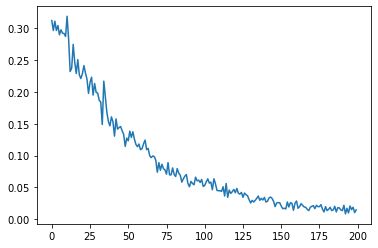

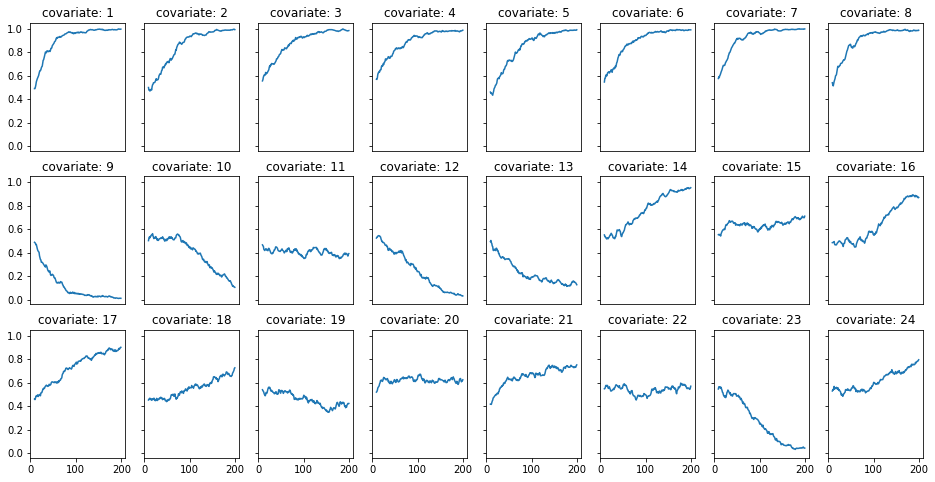

In [8]:
plt.figure()
plt.plot(r_list)
# plt.xlim(0, 1000)
# plt.ylabel('Mean Square Error')
# plt.yticks([12, 20, 40, 60, 80, 100, 120])
# plt.hlines(12, 0, 1000, color='r')


# print(np.where(beta_star != 0)[0] + 1)
# print(beta_star[:8])
action_select = np.array(action_select)

fig, axes = plt.subplots(int(n/8), 8, figsize=(16, 8), sharex=False, sharey=True)
# plt.subplots_adjust(wspace=0.1, hspace=0.1)
# fig.tight_layout()
num = 0
for i in range(int(n/8)):
    for j in range(8):
        axes[i, j].plot(pd.Series(action_select[:, num]).rolling(10).mean())
        axes[i, j].set_title(f'covariate: {num+1}')
        if i != int(n/8)-1: axes[i, j].set_xticks([]) 
        num += 1